In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats

### func

In [81]:
def plot_transition_matrix(transition_matrix_df: pd.DataFrame, title, display_transition_rates=True, text_formatter=lambda x: f"{x:.0f}", ax=None):

    pdf = transition_matrix_df.copy()
    pdf_color = pdf.div(pdf.sum(axis=1), axis=0)

    if ax is None:
        fig, ax = plt.subplots()# figsize = (6, 5)
    else:
        fig = ax.figure

    yticks, yticklabels, ylabel = range(len(pdf.index)), pdf.index, pdf.index.name
    xticks, xticklabels, xlabel = range(len(pdf.columns)), pdf.columns, pdf.columns.name

    cax = ax.imshow(pdf_color.values, cmap="Blues")
    color_threshold = pdf_color.values.max() / 2

    for i in yticks:
        for j in xticks:
            color_value = pdf_color.values[i, j]
            text_color = "white" if color_value > color_threshold else "black"

            va = "bottom" if display_transition_rates else "center"
            ax.text(j, i, text_formatter(pdf.iloc[i, j]), ha="center", va=va, color=text_color)

            if display_transition_rates:
                ax.text(j, i, f"({color_value:.2%})", ha="center", va="top", color=text_color)

    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)
    ax.set_ylabel(ylabel)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_xlabel(xlabel)

    ax.set_title(title)
    # from matplotlib import ticker as mticker
    # fig.colorbar(cax, label="Transition Rate", format=mticker.FuncFormatter(lambda x, _: f"{x*100:.0f}%"))

    return fig, ax


### data

In [2]:
df = pd.read_csv("taxis.csv")
print(f"{df.shape = }")
df.head()

df.shape = (6433, 14)


,pickup,dropoff,passengers,distance,fare,tip,tolls,total,color,payment,pickup_zone,dropoff_zone,pickup_borough,dropoff_borough
0,2019-03-23 20:21:09,2019-03-23 20:27:24,1,1.60,7.0,2.15,0.0,12.95,yellow,credit card,Lenox Hill West,UN/Turtle Bay South,Manhattan,Manhattan
1,2019-03-04 16:11:55,2019-03-04 16:19:00,1,0.79,5.0,0.00,0.0,9.30,yellow,cash,Upper West Side South,Upper West Side South,Manhattan,Manhattan
2,2019-03-27 17:53:01,2019-03-27 18:00:25,1,1.37,7.5,2.36,0.0,14.16,yellow,credit card,Alphabet City,West Village,Manhattan,Manhattan
3,2019-03-10 01:23:59,2019-03-10 01:49:51,1,7.70,27.0,6.15,0.0,36.95,yellow,credit card,Hudson Sq,Yorkville West,Manhattan,Manhattan
4,2019-03-30 13:27:42,2019-03-30 13:37:14,3,2.16,9.0,1.10,0.0,13.40,yellow,credit card,Midtown East,Yorkville West,Manhattan,Manhattan


In [17]:
_ = pd.Categorical(df['pickup_borough'])
_ = pd.Categorical(df['dropoff_borough'])
df['pickup_borough_code'] = pd.Categorical(df['pickup_borough']).codes
df['dropoff_borough_code'] = pd.Categorical(df['dropoff_borough']).codes

df[['pickup_borough','pickup_borough_code', 'dropoff_borough','dropoff_borough_code']].value_counts().reset_index()

,pickup_borough,pickup_borough_code,dropoff_borough,dropoff_borough_code,count
0,Manhattan,2,Manhattan,2,4885
1,Queens,3,Queens,3,349
2,Brooklyn,1,Brooklyn,1,282
3,Queens,3,Manhattan,2,224
4,Manhattan,2,Queens,3,163
5,Manhattan,2,Brooklyn,1,153
6,Brooklyn,1,Manhattan,2,67
7,Bronx,0,Bronx,0,66
8,Queens,3,Brooklyn,1,62
9,Manhattan,2,Bronx,0,55


In [23]:
gdf = df.groupby(["pickup_borough", "dropoff_borough"], dropna=False, observed=False).agg(
    **{
        "n": ("pickup_borough", "size"),
    }
)
gdf.sort_values(by="n", ascending=False).head()

,,n
pickup_borough,dropoff_borough,
Manhattan,Manhattan,4885
Queens,Queens,349
Brooklyn,Brooklyn,282
Queens,Manhattan,224
Manhattan,Queens,163


In [24]:
pdf = df.groupby(["pickup_borough", "dropoff_borough"], dropna=False, observed=False).agg(
    **{
        "n": ("pickup_borough", "size"),
    }
).pivot_table(index="pickup_borough", columns="dropoff_borough", values="n", fill_value=0)
pdf

dropoff_borough,Bronx,Brooklyn,Manhattan,Queens,Staten Island
pickup_borough,,,,,
Bronx,66.0,4.0,25.0,4.0,0.0
Brooklyn,5.0,282.0,67.0,26.0,0.0
Manhattan,55.0,153.0,4885.0,163.0,2.0
Queens,11.0,62.0,224.0,349.0,0.0


In [50]:
pdf_color = pdf.div(pdf.sum(axis=1), axis=0)
pdf_color

dropoff_borough,Bronx,Brooklyn,Manhattan,Queens,Staten Island
pickup_borough,,,,,
Bronx,0.666667,0.040404,0.252525,0.040404,0.00000
Brooklyn,0.013158,0.742105,0.176316,0.068421,0.00000
Manhattan,0.010460,0.029099,0.929060,0.031000,0.00038
Queens,0.017028,0.095975,0.346749,0.540248,0.00000


### plot

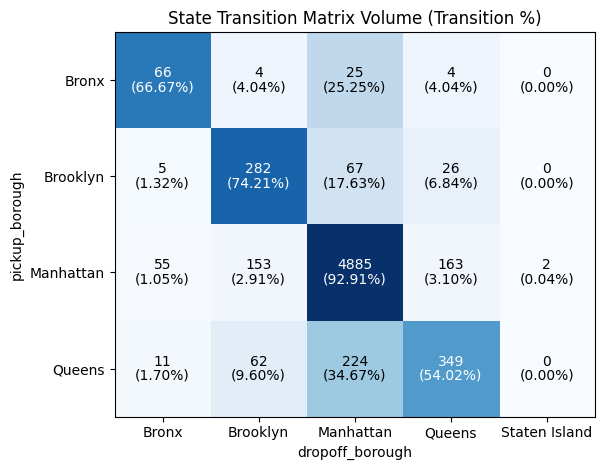

In [80]:

plot_transition_matrix(
    transition_matrix_df=pdf,
    title="State Transition Matrix Volume (Transition %)",
)

plt.tight_layout()
plt.show()
